# Промышленность — задача проекта:

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат.

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.


In [1]:
import pandas as pd # импорт библиотеки pandas
import numpy as np # импорт библиотеки numpy
import matplotlib.pyplot as plt # импорт библиотеки matplotlib
import seaborn as sns # импорт библиотеки seaborn
import re # импорт библиотеки регулярных выражений
from sklearn.model_selection import train_test_split, RandomizedSearchCV # импорт из библиотеки sklearn.model_selection алгоритма train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer # импорт из библиотеки sklearn алгоритма make_scorer, mean_absolute_error
from sklearn.dummy import DummyRegressor # импорт из библиотеки sklearn алгоритма DummyRegressor
from lightgbm import LGBMRegressor # импорт из библиотеки lightgbm алгоритма LGBMRegressor
from catboost import CatBoostRegressor # импорт из библиотеки catboost алгоритма CatBoostRegressor

In [2]:
RANDOM_STATE = 80822

# Откроем файлы и изучим их.

In [3]:
data_arc = pd.read_csv('***')
data_bulk = pd.read_csv('***')
data_bulk_time = pd.read_csv('***')
data_gas = pd.read_csv('***')
data_temp = pd.read_csv('***')
data_wire = pd.read_csv('***')
data_wire_time = pd.read_csv('***')

In [4]:
# напишем функцию по изучению данных
def data_info(data):
    return data.info(), \
           print(data.describe()), \
           display(data.head(7)), \
           print('Количество дубликатов:', data.duplicated().sum()), \
           print('Количество пропущенных партий в датасете:', len(set(range(1, 3242)) - set(data['key'])))

## Данные об электродах

In [5]:
data_info(data_arc);

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
                key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.670441             0.452592
std      934.571502           0.408159             5.878702
min        1.000000           0.030002          -715.504924
25%      806.000000           0.395297             0.290991
50%     1617.000000           0.555517             0.415962
75%     2429.000000           0.857034             

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914


Количество дубликатов: 0
Количество пропущенных партий в датасете: 27


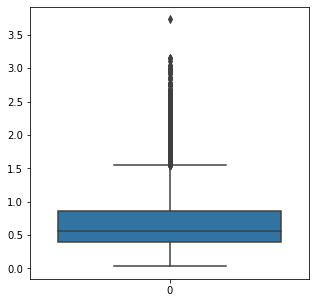

In [6]:
plt.figure(figsize=(5,5))
sns.boxplot(data = data_arc['Активная мощность']);

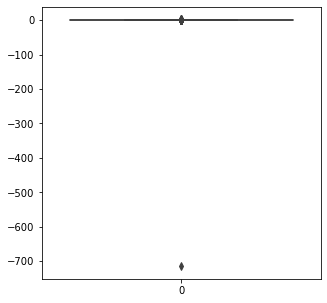

In [7]:
plt.figure(figsize=(5,5))
sns.boxplot(data = data_arc['Реактивная мощность'] );

Пропусков в данных нет. Всего 3241 партия. Присутствуют выбросы в активной мощности. В реактивной мощности один сильно выделяющийся выброс. Реактивная мощность может быть отрицательной, если нагрузка имеет активно-ёмкостный характер. Но похоже, что здесь ошибка, он один и характер нагрузки везде одинаковый. Партию нужно будет удалить.

 27 значений партий нет в таблице. Странно, что нет данных об этих партиях.

## Данные о подаче сыпучих материалов (объём)

In [8]:
data_info(data_bulk);

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
               key      Bulk 1      Bulk 2       Bulk 3       Bulk 4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean   1624.

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0


Количество дубликатов: 0
Количество пропущенных партий в датасете: 112


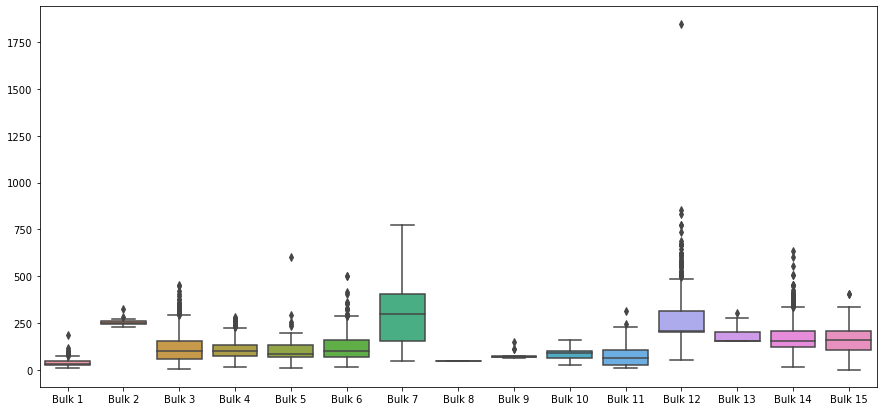

In [9]:
plt.figure(figsize=(15,7))
sns.boxplot(data = data_bulk.drop('key', axis=1));

Всего используется 15 сыпучих материалов. Много пропусков, значит в данной партии этот материал не добавляли. Логично заполнить пропуски нулями. Материал №8 использовался всего 1 раз. Почти везде есть выбросы, Особенно заметные у материала №12.

112 значений партий нет в таблице.

## Данные о подаче сыпучих материалов (время)

In [10]:
data_info(data_bulk_time);

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
               key
count  3129.000000
mean   1624.383509
std     933.337642
min       1.000000
25%     816.000000
50%    1622.000000
75%    2431.000000
max    3241.000000


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19


Количество дубликатов: 0
Количество пропущенных партий в датасете: 112


Аналог предыдущей таблицы. Время, когда были добавлены материалы.

## Данные о продувке сплава газом

In [11]:
data_info(data_gas);

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
               key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267


Количество дубликатов: 0
Количество пропущенных партий в датасете: 2


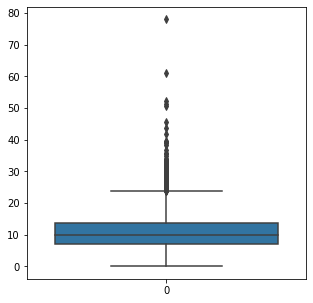

In [12]:
plt.figure(figsize=(5,5))
sns.boxplot(data = data_gas['Газ 1']);

Пропусков нет, присутствуют выбросы.

2 значений партий нет в таблице.

## Результаты измерения температуры

In [13]:
data_info(data_temp);

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
                key   Температура
count  15907.000000  13006.000000
mean    1607.880870   1591.840920
std      942.212073     21.375851
min        1.000000   1191.000000
25%      790.000000   1581.000000
50%     1618.000000   1591.000000
75%     2427.000000   1601.000000
max     3241.000000   1705.000000


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0


Количество дубликатов: 0
Количество пропущенных партий в датасете: 25


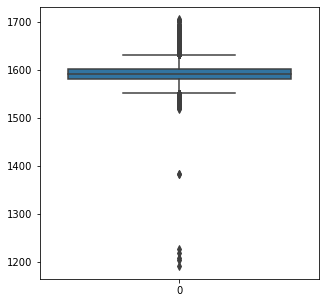

In [14]:
plt.figure(figsize=(5,5))
sns.boxplot(data = data_temp['Температура']);

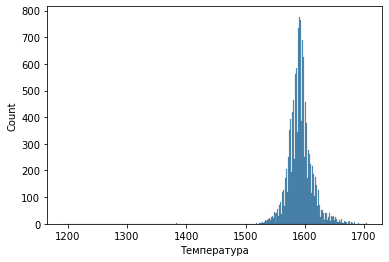

In [15]:
sns.histplot(data = data_temp['Температура']);

In [16]:
low_temp = data_temp.query('Температура < 1500')
low_temp

,key,Время замера,Температура
4350,867,2019-06-04 14:21:00,1191.0
5978,1214,2019-06-16 05:32:00,1208.0
7958,1619,2019-06-30 11:03:54,1218.0
8913,1818,2019-07-07 00:30:49,1383.0
8914,1818,2019-07-07 00:31:40,1383.0
10127,2052,2019-07-21 14:51:40,1227.0
12564,2561,2019-08-08 07:34:15,1204.0


In [17]:
low_temp_list = list(set(low_temp['key']))
data_temp.query('key in @low_temp_list')

,key,Время замера,Температура
4350,867,2019-06-04 14:21:00,1191.0
4351,867,2019-06-04 14:29:35,1575.0
4352,867,2019-06-04 14:30:29,1576.0
4353,867,2019-06-04 14:43:10,1571.0
4354,867,2019-06-04 14:52:54,1600.0
4355,867,2019-06-04 14:57:17,1599.0
5978,1214,2019-06-16 05:32:00,1208.0
5979,1214,2019-06-16 05:49:01,1608.0
5980,1214,2019-06-16 05:51:28,1608.0
5981,1214,2019-06-16 05:51:38,1608.0


In [18]:
data_temp['Температура'].isnull().mean() # процент пропусков

0.18237254039102282

In [19]:
data_temp['key'].value_counts() # количество измерений температуры в партии

46      16
1214    16
44      16
1513    16
2108    15
        ..
1160     2
982      2
2456     2
195      1
279      1
Name: key, Length: 3216, dtype: int64

Присутствуют выбросы с низкой температурой, их немного - 7 штук. В этих партиях первый замер показывал низкую температуру, здесь затраты энергии на нагрев до нужной температуры высоки. В одном случае температура падала после нескольких итераций. В последней партии сплошные пропуски.

2901 пропуск по температуре. Данные имеют почти нормальное распределение, медиана почти равна среднему.

25 значений партий нет в таблице.

## Данные о проволочных материалах (объём)

In [20]:
data_info(data_wire);

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
               key       Wire 1       Wire 2      Wire 3      Wire 4  Wire 5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442842  15.132   
std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN   
min       1.000000     1.918800     0.030160    0.144144   24.148801  15.132 

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Количество дубликатов: 0
Количество пропущенных партий в датасете: 160


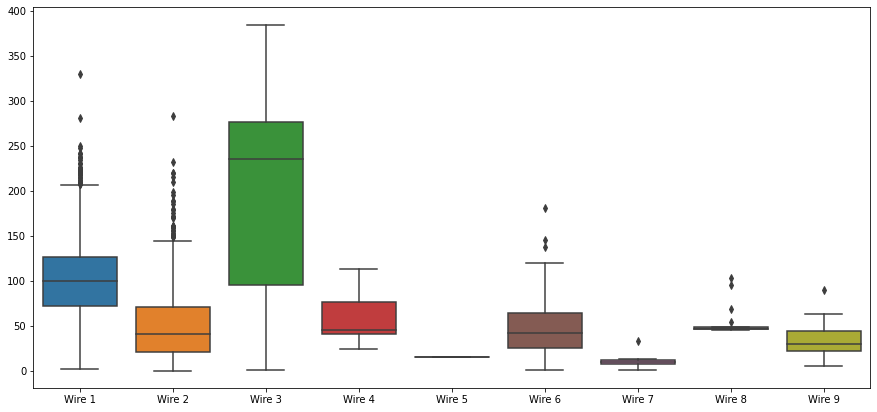

In [21]:
plt.figure(figsize=(15,7))
sns.boxplot(data = data_wire.drop('key', axis=1));

Присутствуют выбросы. Пропуски можно заполнить нулями. Материал №5 использовался всего 1 раз.

160 значений партий нет в таблице.

## Данные о проволочных материалах (время)

In [22]:
data_info(data_wire_time);

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
               key
count  3081.000000
mean   1623.426485
std     932.996726
min       1.000000
25%     823.000000
50%    1619.000000
75%    2434.000000
max    3241.000000


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Количество дубликатов: 0
Количество пропущенных партий в датасете: 160


Аналог предыдущей таблицы. Время, когда были добавлены материалы.

**Выводы**

- Часть данных по партиям отсутствует, значит не в каждой партии добавляли тот или иной материал.
- По температуре (целевой признак) 20% пропусков
- Присутвует большое число выбросов, что может отразится на точности модели.
- Дубликатов нет

# План проекта

1. Предобработка данных: заполнение пропусков, правка названий столбцов.
2. Объединение данных в один датасет: создание признаков, определение целевого признака.
3. Деление на выборки.
4. Обучение моделей.
5. Выбор лучшей модели: проверка на тестовой выборке.

# 1. Предобработка данных

## 1.1 Приведение столбцов к стандарту pep 8

In [23]:
data_arc = data_arc.rename(columns={'Начало нагрева дугой':'arc_heating_start',
                                    'Конец нагрева дугой':'arc_heating_end',
                                    'Активная мощность':'active_power',
                                    'Реактивная мощность':'reactive_power'})
data_arc.head(1)

,key,arc_heating_start,arc_heating_end,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084


In [24]:
data_bulk.columns = [re.sub(r' ', r'_', name).lower() for name in data_bulk.columns]
data_bulk.head(1)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0


In [25]:
data_bulk_time.columns = [re.sub(r' ', r'_', name).lower() for name in data_bulk_time.columns]
data_bulk_time.head(1)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52


In [26]:
data_gas = data_gas.rename(columns={'Газ 1':'gas'})
data_gas.head(1)

,key,gas
0,1,29.749986


In [27]:
data_temp = data_temp.rename(columns={'Время замера':'time_temp_measure',
                                      'Температура':'temp'})
data_temp.head(1)

,key,time_temp_measure,temp
0,1,2019-05-03 11:16:18,1571.0


In [28]:
data_wire.columns = [re.sub(r' ', r'_', name).lower() for name in data_wire.columns]
data_wire.head(1)

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
data_wire_time.columns = [re.sub(r' ', r'_', name).lower() for name in data_wire_time.columns]
data_wire_time.head(1)

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 1.2 Заполнение пропусков, удаление лишних данных

**Данные по электродам**

In [30]:
data_arc[data_arc['reactive_power']<0]['key'] # находим партию с отрицательной реактивной мощностью

9780    2116
Name: key, dtype: int64

In [31]:
# удаляем эту партию, чтобы не осталось не верных данных, после удаления одного процесса из партии
data_arc = data_arc[data_arc['key'] != 2116].reset_index(drop=True) 
# проверяем
data_arc[data_arc['key'] == 2116] 

,key,arc_heating_start,arc_heating_end,active_power,reactive_power


**Сыпучие материалы(объем)**

In [32]:
data_bulk.isna().mean()*100 # процент пропусков

key         0.000000
bulk_1     91.946309
bulk_2     99.296900
bulk_3     58.517098
bulk_4     67.593480
bulk_5     97.539150
bulk_6     81.591563
bulk_7     99.201023
bulk_8     99.968041
bulk_9     99.392777
bulk_10    94.375200
bulk_11    94.343241
bulk_12    21.700224
bulk_13    99.424736
bulk_14    10.322787
bulk_15    28.155960
dtype: float64

In [33]:
# удалим столбцы, где меньше всего значений (99% пропусков), чтобы не засорять датасет пустыми признаками,
# заказчик подтвердил, что удаление корректно
data_bulk = data_bulk.drop(data_bulk[['bulk_2','bulk_7','bulk_8','bulk_9','bulk_13']], axis=1)
# заполняем нулям пропуски
data_bulk = data_bulk.fillna(0)

In [34]:
data_bulk.head(1)

,key,bulk_1,bulk_3,bulk_4,bulk_5,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15
0,1,0.0,0.0,43.0,0.0,0.0,0.0,0.0,206.0,150.0,154.0


**Сыпучие материалы(время)**

In [35]:
# удалим те же столбцы
data_bulk_time = data_bulk_time.drop(data_bulk_time[['bulk_2','bulk_7','bulk_8','bulk_9','bulk_13']], axis=1)
# заполняем нулям пропуски
data_bulk_time = data_bulk_time.fillna(0)

In [36]:
data_bulk_time.head(1)

,key,bulk_1,bulk_3,bulk_4,bulk_5,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15
0,1,0,0,2019-05-03 11:21:30,0,0,0,0,2019-05-03 11:03:52,2019-05-03 11:03:52,2019-05-03 11:03:52


**Продувка газом**

По газу нет пропусков, выбросы трогать не будем, других проблем нет. Оставляем без изменений.

**Проволочные материалы(объем)**

In [37]:
data_wire.isna().mean()*100

key        0.000000
wire_1     0.843882
wire_2    64.978903
wire_3    97.955209
wire_4    99.545602
wire_5    99.967543
wire_6    97.630639
wire_7    99.642973
wire_8    99.383317
wire_9    99.058747
dtype: float64

In [38]:
# удалим столбцы, где меньше всего значений (99% пропусков), чтобы не засорять датасет пустыми признаками,
# заказчик подтвердил, что удаление корректно
data_wire = data_wire.drop(data_wire[['wire_4','wire_5','wire_7','wire_8','wire_9']], axis=1)
# заполняем нулям пропуски
data_wire = data_wire.fillna(0)

In [39]:
data_wire.head(1)

,key,wire_1,wire_2,wire_3,wire_6
0,1,60.059998,0.0,0.0,0.0


**Проволочные материалы(время)**

In [40]:
# удалим те же столбцы
data_wire_time = data_wire_time.drop(data_wire_time[['wire_4','wire_5','wire_7','wire_8','wire_9']], axis=1)
# заполняем нулям пропуски
data_wire_time = data_wire_time.fillna(0)

In [41]:
data_wire_time.head(1)

,key,wire_1,wire_2,wire_3,wire_6
0,1,2019-05-03 11:11:41,0,0,0


**Температура**

In [42]:
# удалим партии, где температура была меньше 1500 градусов
data_temp = data_temp.query('key != @low_temp_list')

In [43]:
# проверяем
data_temp.query('key in @low_temp_list')

,key,time_temp_measure,temp


In [44]:
# удалим партии с пропусками температуры
isna_temp_list = list(set(data_temp[data_temp['temp'].isna()]['key']))
data_temp = data_temp.query('key != @isna_temp_list')

In [45]:
# проверяем
data_temp.query('key in @isna_temp_list')

,key,time_temp_measure,temp


In [46]:
# удалим партии, где всего одно измерение температуры
low_count_temp_list = data_temp.groupby('key').agg({'temp':['count']}).reset_index()
low_count_temp_list = low_count_temp_list[low_count_temp_list['temp','count']<2]['key']

In [47]:
data_temp = data_temp.query('key not in @low_count_temp_list').reset_index(drop=True) 

In [48]:
# проверяем
data_temp.query('key in @low_count_temp_list')

,key,time_temp_measure,temp


**Выводы**

- Столбцы приведены к стандарту pep 8
- Пропуски заполнены нулями
- Удален ключ(партия) с отрицательным значением реактивной мощности
- Удалены ключи с низким значением температуры (меньше 1500), выбросы плохо влияют на обучаемость модели
- Удалены ключи с пропусками температуры и один значением
- Данные готовы для объединения

# 2. Объединение данных

## Подготовка для объединения, создание признаков

In [49]:
# создадим таблицу с подсчетом итераций в партии
count_key = data_temp['key'].value_counts().sort_index().reset_index().rename(columns={'index':'key','key':'count'})
count_key

,key,count
0,1,5
1,2,6
2,3,5
3,4,3
4,5,2
...,...,...
2465,2495,3
2466,2496,4
2467,2497,2
2468,2498,5


**Подготовка таблицы с электродами**

In [50]:
# время нагрева в секундах
data_arc['arc_heating_time'] = (pd.to_datetime(data_arc['arc_heating_end']) 
                             - pd.to_datetime(data_arc['arc_heating_start'])).dt.seconds
# полная мощность
data_arc['full_power'] = (data_arc['active_power']**2 + data_arc['reactive_power']**2)**0.5
# энергия
data_arc['energy'] = data_arc['full_power'] * (data_arc['arc_heating_time']/3600)

data_arc.head(7)

,key,arc_heating_start,arc_heating_end,active_power,reactive_power,arc_heating_time,full_power,energy
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228,1.193639,0.075597
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185,0.959010,0.049282
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172,0.896038,0.042811
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365,1.970470,0.199784
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148,0.807239,0.033186
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043,137,0.521549,0.019848
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914,338,1.574162,0.147796


In [51]:
# группировка по партии и суммирование значений
data_full = data_arc.groupby('key').sum()
# отношение активной к реактивной мощности 
data_full['power_ratio'] = data_full['active_power'] / data_full['reactive_power']

In [52]:
# соединение таблицы по электродам и количества итераций в партии
data_full = data_full.merge(count_key, on='key')
data_full

,key,active_power,reactive_power,arc_heating_time,full_power,energy,power_ratio,count
0,1,4.878147,3.183241,1098,5.826395,0.400660,1.532447,5
1,2,3.052598,1.998112,811,3.649216,0.244787,1.527741,6
2,3,2.525882,1.599076,655,2.989534,0.145852,1.579589,5
3,4,3.209250,2.060298,741,3.814962,0.221364,1.557663,3
4,5,3.347173,2.252643,869,4.035758,0.333094,1.485887,2
...,...,...,...,...,...,...,...,...
2464,2495,3.210690,2.360777,723,3.986869,0.216338,1.360014,3
2465,2496,4.203064,2.810185,940,5.057033,0.243128,1.495654,4
2466,2497,2.212379,1.851269,569,2.885017,0.154703,1.195061,2
2467,2498,3.408725,2.355428,750,4.143749,0.213283,1.447179,5


In [53]:
# преобразование в datetime
data_arc['arc_heating_start'] = pd.to_datetime(data_arc['arc_heating_start'])
data_arc['arc_heating_end'] = pd.to_datetime(data_arc['arc_heating_end'])

In [54]:
# добавление времени начала нагрева дуги в партии
data_full = data_full.merge(data_arc.groupby('key')['arc_heating_start'].min(), on='key')

In [55]:
# добавление времени окончания нагрева дуги в партии
data_full = data_full.merge(data_arc.groupby('key')['arc_heating_end'].max(), on='key')

In [56]:
data_full.head(3)

,key,active_power,reactive_power,arc_heating_time,full_power,energy,power_ratio,count,arc_heating_start,arc_heating_end
0,1,4.878147,3.183241,1098,5.826395,0.400660,1.532447,5,2019-05-03 11:02:14,2019-05-03 11:28:37
1,2,3.052598,1.998112,811,3.649216,0.244787,1.527741,6,2019-05-03 11:34:14,2019-05-03 11:53:18
2,3,2.525882,1.599076,655,2.989534,0.145852,1.579589,5,2019-05-03 12:06:54,2019-05-03 12:32:19


**Добавление таблиц с сыпучими материалами, проволокой и газом**

In [57]:
# добавление таблицы сыпучих материалов
data_full = data_full.merge(data_bulk, on='key')

In [58]:
# добавление таблицы с газом
data_full = data_full.merge(data_gas, on='key')

In [59]:
# добавление таблицы с проволочными материалами
data_full = data_full.merge(data_wire, on='key')

**Подготовка таблицы с температурой**

In [60]:
# преобразование в datetime
data_temp['time_temp_measure'] = pd.to_datetime(data_temp['time_temp_measure'])

In [61]:
# группировка по ключу и выделение времени первого замера температуры
data_temp_first = data_temp.groupby('key')['time_temp_measure'].min().reset_index()
data_temp_first.head(3)

,key,time_temp_measure
0,1,2019-05-03 11:16:18
1,2,2019-05-03 11:37:27
2,3,2019-05-03 12:13:17


In [62]:
# добавление первого замера температуры
data_temp_merged = data_temp_first.merge(data_temp[['temp','time_temp_measure']], on='time_temp_measure') \
                  .rename(columns={'temp':'first_temp','time_temp_measure':'first_temp_measure'})
data_temp_merged.head(3)

,key,first_temp_measure,first_temp
0,1,2019-05-03 11:16:18,1571.0
1,2,2019-05-03 11:37:27,1581.0
2,3,2019-05-03 12:13:17,1596.0


In [63]:
# добавление времени последнего замера температуры
data_temp_last = pd.to_datetime(data_temp.groupby('key')['time_temp_measure'].max()).reset_index()
data_temp_merged = data_temp_merged.merge(data_temp_last, on='key')
data_temp_merged.head(3)

,key,first_temp_measure,first_temp,time_temp_measure
0,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39
1,2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12
2,3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57


In [64]:
# добавление последнего замера температуры
data_temp_merged = data_temp_merged.merge(data_temp[['temp','time_temp_measure']], on='time_temp_measure') \
                  .rename(columns={'temp':'last_temp','time_temp_measure':'last_temp_measure'})
data_temp_merged.head(3)

,key,first_temp_measure,first_temp,last_temp_measure,last_temp
0,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0


In [65]:
# добавление времени между первым и последним замером
data_temp_merged['time_temp_measure_sec'] = (data_temp_merged['last_temp_measure'] 
                                            - data_temp_merged['first_temp_measure']).dt.seconds
data_temp_merged.head(3)

,key,first_temp_measure,first_temp,last_temp_measure,last_temp,time_temp_measure_sec
0,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,861
1,2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,1305
2,3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0,1300


In [66]:
# соединение с общей таблицей
data_full = data_full.merge(data_temp_merged, on='key')
data_full.head(3)

,key,active_power,reactive_power,arc_heating_time,full_power,energy,power_ratio,count,arc_heating_start,arc_heating_end,...,gas,wire_1,wire_2,wire_3,wire_6,first_temp_measure,first_temp,last_temp_measure,last_temp,time_temp_measure_sec
0,1,4.878147,3.183241,1098,5.826395,0.400660,1.532447,5,2019-05-03 11:02:14,2019-05-03 11:28:37,...,29.749986,60.059998,0.0,0.0,0.0,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,861
1,2,3.052598,1.998112,811,3.649216,0.244787,1.527741,6,2019-05-03 11:34:14,2019-05-03 11:53:18,...,12.555561,96.052315,0.0,0.0,0.0,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,1305
2,3,2.525882,1.599076,655,2.989534,0.145852,1.579589,5,2019-05-03 12:06:54,2019-05-03 12:32:19,...,28.554793,91.160157,0.0,0.0,0.0,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0,1300


**Добавление признаков**

In [67]:
# добавление времени между первым замером температуры и началом работы дуги
data_full['first_temp_arc_start_sec'] = (data_full['first_temp_measure'] - data_full['arc_heating_start']).dt.seconds

In [68]:
# добавление времени между последним замером температуры и началом работы дуги
data_full['last_temp_arc_start_sec'] = (data_full['last_temp_measure'] - data_full['arc_heating_start']).dt.seconds

In [69]:
# удаление столбцов с датой и номером партии
data_full = data_full.drop(['key','first_temp_measure', 'last_temp_measure', 'arc_heating_start', 'arc_heating_end'],axis=1)

In [70]:
data_full

,active_power,reactive_power,arc_heating_time,full_power,energy,power_ratio,count,bulk_1,bulk_3,bulk_4,...,gas,wire_1,wire_2,wire_3,wire_6,first_temp,last_temp,time_temp_measure_sec,first_temp_arc_start_sec,last_temp_arc_start_sec
0,4.878147,3.183241,1098,5.826395,0.400660,1.532447,5,0.0,0.0,43.0,...,29.749986,60.059998,0.00000,0.0,0.0,1571.0,1613.0,861,844,1705
1,3.052598,1.998112,811,3.649216,0.244787,1.527741,6,0.0,0.0,73.0,...,12.555561,96.052315,0.00000,0.0,0.0,1581.0,1602.0,1305,193,1498
2,2.525882,1.599076,655,2.989534,0.145852,1.579589,5,0.0,0.0,34.0,...,28.554793,91.160157,0.00000,0.0,0.0,1596.0,1599.0,1300,383,1683
3,3.209250,2.060298,741,3.814962,0.221364,1.557663,3,0.0,0.0,81.0,...,18.841219,89.063515,0.00000,0.0,0.0,1601.0,1625.0,388,800,1188
4,3.347173,2.252643,869,4.035758,0.333094,1.485887,2,0.0,0.0,78.0,...,5.413692,89.238236,9.11456,0.0,0.0,1576.0,1602.0,762,726,1488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2319,3.210690,2.360777,723,3.986869,0.216338,1.360014,3,0.0,21.0,0.0,...,7.125735,89.150879,0.00000,0.0,0.0,1570.0,1591.0,1137,280,1417
2320,4.203064,2.810185,940,5.057033,0.243128,1.495654,4,0.0,0.0,63.0,...,9.412616,114.179527,0.00000,0.0,0.0,1554.0,1591.0,1618,168,1786
2321,2.212379,1.851269,569,2.885017,0.154703,1.195061,2,0.0,0.0,85.0,...,6.271699,94.086723,9.04800,0.0,0.0,1571.0,1589.0,717,232,949
2322,3.408725,2.355428,750,4.143749,0.213283,1.447179,5,0.0,90.0,0.0,...,14.953657,118.110717,0.00000,0.0,0.0,1591.0,1594.0,1302,363,1665


In [71]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   active_power              2324 non-null   float64
 1   reactive_power            2324 non-null   float64
 2   arc_heating_time          2324 non-null   int64  
 3   full_power                2324 non-null   float64
 4   energy                    2324 non-null   float64
 5   power_ratio               2324 non-null   float64
 6   count                     2324 non-null   int64  
 7   bulk_1                    2324 non-null   float64
 8   bulk_3                    2324 non-null   float64
 9   bulk_4                    2324 non-null   float64
 10  bulk_5                    2324 non-null   float64
 11  bulk_6                    2324 non-null   float64
 12  bulk_10                   2324 non-null   float64
 13  bulk_11                   2324 non-null   float64
 14  bulk_12 

**Выводы**

- Данные были сгруппированы по партиям
- Добавлены 8 дополнительных признаков
- Данных не много, валидационную выборку использовать не будем
- Данные готовы для обучения

# 3. Деление на выборки

In [72]:
features = data_full.drop('last_temp', axis=1) # признаки
target = data_full['last_temp'] # целевой признак

In [73]:
# разделение на обучающую и тестовую выборки 75/25
features_train, features_test, target_train, target_test = train_test_split(
                                                           features, target, test_size=0.25, random_state=RANDOM_STATE)

In [74]:
print('Обучающая выборка:',round(features_train.shape[0]/features.shape[0]*100,1),'%')
print('Тестовая выборка:',round(features_test.shape[0]/features.shape[0]*100,1),'%')

Обучающая выборка: 75.0 %
Тестовая выборка: 25.0 %


# 4. Обучение моделей

    Будем использовать 2 модели градиентного бустинга: LightGBM и CatBoost совместно с RandomizedSearchCV.
    У LightGBM высокая скорость обучения и хороший результат предсказаний.
    CatBoost выделяется хорошим результатом предсказаний даже с базовыми параметрами.
    RandomizedSearchCV быстро подбирает параметры в отличии от GridSearchCV.

In [75]:
mae = make_scorer(mean_absolute_error, greater_is_better=False) # добавление скорера

**LightGBM**

In [76]:
# гиперпараметры
param_lgbm = {'max_depth':[2,4,6,8,10,12,15],
              'random_state':[RANDOM_STATE],
              'n_estimators':[200,300,400,500,550,1000,1200],
              'num_leaves':[10,20,30,40,50,60,70,80,100],
              'learning_rate':[0.1,0.2,0.02,0.03,0.04,0.05]}

In [77]:
random_lgbm = RandomizedSearchCV(LGBMRegressor(), 
                                 param_lgbm, 
                                 random_state=RANDOM_STATE, 
                                 return_train_score=True,
                                 cv=5, 
                                 n_jobs=-1,
                                 scoring=mae)

In [78]:
%%time
# обучение
random_lgbm.fit(features_train, target_train)

Wall time: 6.78 s


RandomizedSearchCV(cv=5, estimator=LGBMRegressor(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.2, 0.02, 0.03,
                                                          0.04, 0.05],
                                        'max_depth': [2, 4, 6, 8, 10, 12, 15],
                                        'n_estimators': [200, 300, 400, 500,
                                                         550, 1000, 1200],
                                        'num_leaves': [10, 20, 30, 40, 50, 60,
                                                       70, 80, 100],
                                        'random_state': [80822]},
                   random_state=80822, return_train_score=True,
                   scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [79]:
random_lgbm.best_params_

{'random_state': 80822,
 'num_leaves': 100,
 'n_estimators': 550,
 'max_depth': 12,
 'learning_rate': 0.02}

In [80]:
print('MAE LightGBM на кросс валидации:', round(random_lgbm.best_score_,2))

MAE LightGBM на кросс валидации: -5.46


**CatBoost**

In [81]:
# гиперпараметры
param_cb = {'depth':[3,4,5,6],
            'random_state':[RANDOM_STATE],
            'n_estimators':[500,700,1000],
            'learning_rate':[0.1,0.2]}

In [82]:
random_cb = RandomizedSearchCV(CatBoostRegressor(), 
                               param_cb, 
                               random_state=RANDOM_STATE, 
                               return_train_score=True,
                               cv=5, 
                               n_jobs=-1,
                               scoring=mae)

In [83]:
# категориальный признак
cat_features = ['count']

In [84]:
%%time
# обучение
random_cb.fit(features_train, target_train, cat_features = cat_features, verbose=1000)

0:	learn: 10.8441824	total: 176ms	remaining: 1m 27s
499:	learn: 3.1627678	total: 10.2s	remaining: 0us
Wall time: 1min 57s


RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostRegressor object at 0x000002939CE42EE0>,
                   n_jobs=-1,
                   param_distributions={'depth': [3, 4, 5, 6],
                                        'learning_rate': [0.1, 0.2],
                                        'n_estimators': [500, 700, 1000],
                                        'random_state': [80822]},
                   random_state=80822, return_train_score=True,
                   scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [85]:
random_cb.best_params_

{'random_state': 80822, 'n_estimators': 500, 'learning_rate': 0.1, 'depth': 5}

In [86]:
print('MAE CatBoost на кросс валидации:', round(random_cb.best_score_,2))

MAE CatBoost на кросс валидации: -5.28


## Проверка моделей на адекватность

In [87]:
# вызов константной модели
dummy = DummyRegressor(strategy="median")
# обучение модели
dummy.fit(features_train,target_train)
# предсказания модели
prediction_dummy = dummy.predict(features_test)
print('MAE константной модели на тестовой выборке:', round(mean_absolute_error(target_test, prediction_dummy),2))

MAE константной модели на тестовой выборке: 8.15


**Вывод**

- Обе модели показали себя отлично и прошли тест на адекватность
- CatBoost справилась чуть лучше, но значительно дольше
- Выберем модель CatBoost с МАЕ = 5,28

# 5. Тестирование лучшей модели

In [88]:
prediction_cb_test = random_cb.predict(features_test)

In [89]:
print('MAE CatBoost на тестовой выборке:', round(mean_absolute_error(target_test, prediction_cb_test),2))

MAE CatBoost на тестовой выборке: 5.49


## График предсказаний

In [90]:
# перевод в вектор
target_test = target_test.values

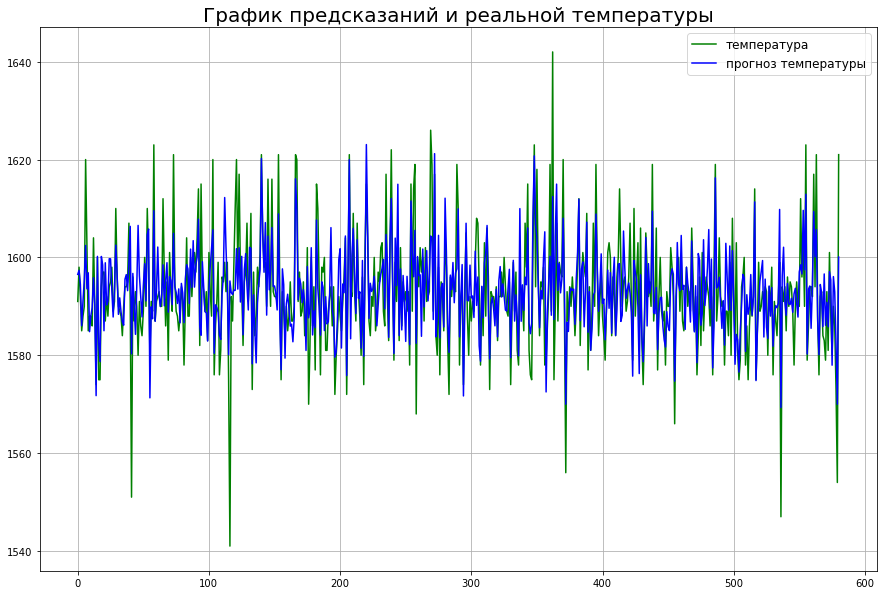

In [91]:
plt.figure(figsize=(15,10))
plt.title('График предсказаний и реальной температуры', fontsize=20)
sns.lineplot(data=target_test, color='g')
sns.lineplot(data=prediction_cb_test, color='b', )
plt.legend(['температура', 'прогноз температуры'], fontsize=12)
plt.grid()
plt.show()

Модель хорошо справляется на небольшом разбросе температур, но выбросы не предугадывает.

## Важность признаков

In [92]:
# достанем лучшие параметры из рандомайзера и по ним обучим модель
params = random_cb.best_params_
model = CatBoostRegressor(**params,silent=True)
model.fit(features_train, target_train, verbose=1000);

0:	learn: 10.8155086	total: 17.2ms	remaining: 8.59s
499:	learn: 3.0253033	total: 700ms	remaining: 0us


In [93]:
# достанем из модели важность признаков
importance = pd.Series(model.feature_importances_, index=features_train.columns).sort_values(ascending=False)

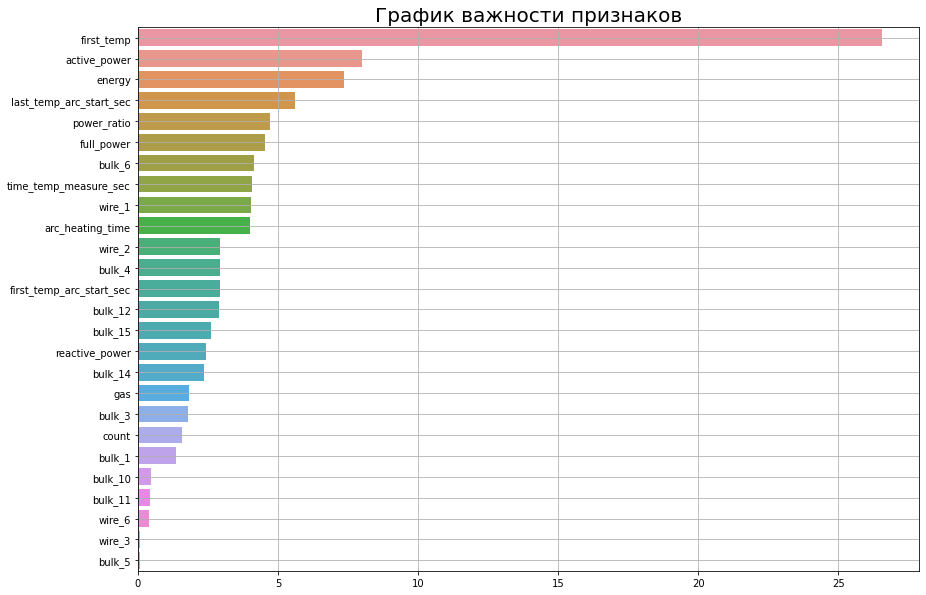

In [94]:
# построение графика важности признаков
plt.figure(figsize=(14,10))
plt.title('График важности признаков', fontsize=20)
sns.barplot(x=importance, y=importance.index)
plt.grid()
plt.show()

# 6. Общий вывод

- Выбор метрики пал на MAE, для удобства интерпретации.
- Удалось достичь на модели CatBoostRegressor MAE = 5,49 на тестовой выборке. Модель ошибается в среднем на 5,5 градуса.
- Самый важный признак с большим отрывом: первое измерение температуры. Далее по важности идут: активная мощность и энергия.
- Обе модели прошли тест на адекватность. Значения метрик меньше константной модели.

# Отчет:

 **Признаки, которые были использованы для обучения:** 
- активная мощность
- реактивная мощность
- время нагрева дугой в секундах
- полная мощность
- энергия
- отношение активной к реактивной мощности
- количество итераций в партии
- сыпучие материалы (1,3,4,5,6,10,11,12,14,15)
- газ
- проволочные материалы (1,2,3,6)
- первый замер температуры
- время между первым и последним замером температуры
- время между первым замером температуры и началом работы дуги
- время между последним замером температуры и началом работы дуги

**Предобработка признаков:**
- С активной мощностью не было проблем, оставил без изменений. У реактивной мощности был один выброс с сильно отрицательным значением, на 2 порядка отличающимся от остальных данных. Я удалил всю партию с этим выбросом, чтобы не осталось не верных данных после удаления лишь одной итерации в партии.
- Известно время начала работы дуги и конец работы дуги, для каждой итерации для каждой партии. Вычислил время нагрева дугой для каждой партии в секундах.
- Полная мощность вычисляется по формуле из активной и реактивной мощности.
- Энергию посчитал по формуле из полной мощности и времени нагрева дугой.
- Сыпучие материалы не все были использованы в признаках. Материал №8, например, использовался всего 1 раз. Материал №13 - 18 раз. Но я решил удалить материалы с 99% процентов пропусков, чтобы не засорять датасет почти пустыми признаками. Поэтому из датасета убраны материалы № 2,7,8,9,13, а пропуски заполнены нулями. Заказчик подтвердил корректность удаления пустых признаков.
- Аналогичная ситуация с проволочными материалами. Удалены материалы № 4,5,7,8,9 с 99% пропусков. Пропуски заполнены нулями.
- С газом аномалий не обнаружено, оставлен без изменений. Пропусков не было.
- Добавил время в секундах между первым и последним замером температуры.
- Так же добавил время между первым замером температуры и началом работы дуги, и последним замером температуры и началом работы дуги. Я подумал, что из связи между замером температуры и нагревом может получится хороший признак.
- Были убраны партии, где температура хотя бы на одном замере была меньше 1500 градусов. Математически это выброс, но на производстве такое случается. Разный состав металла, разная температура. Но для лучшей работы модели я решил удалить эти партии, 6 штук.
- Так же были удалены партии с пропусками по температуре, и где был всего 1 замер по температуре.

**Модель:**
- Я использовал 2 модели градиентного бустинга LightGBM и Catboost.
- Catboost дала результат лучше на 0,18 градуса на кросс валидации, чем LightGBM.
- Гиперпараметры лучшей модели: 'random_state': 80822, 'n_estimators': 500, 'learning_rate': 0.1, 'depth': 5. Остальное по умолчанию.
- Итоговая метрика Catboost на тестовой выборке MAE = 5,49.